# Azure Backend API Testing

This notebook allows direct testing of the Azure backend API endpoints.

## MMLU Testing Cell

In [ ]:
# MMLU Single Subject Benchmarking with Adaptive Backend
import random
import time
from datetime import datetime

import pandas as pd
import requests
from datasets import load_dataset

# Configuration
BASE_URL = "https://backend-dev.mangoplant-a7a21605.swedencentral.azurecontainerapps.io"

# Focus on the MOST IMPORTANT subject for AI benchmarking
TARGET_SUBJECT = "college_mathematics"  # Math is the gold standard for AI reasoning


def run_single_subject_mmlu_benchmark():
    """
    Run MMLU benchmark on COLLEGE MATHEMATICS only
    ~100 questions, perfect for quick validation
    
    Estimated time: 5-15 minutes
    """
    print("=== SINGLE SUBJECT MMLU BENCHMARK ===")
    print(f"🎯 Testing ONLY: {TARGET_SUBJECT}")
    print("📊 Math is the gold standard for AI reasoning capabilities")
    print("⏰ Estimated time: 5-15 minutes")
    print("💰 Cost: Very low API usage\n")

    # Quick start
    print("▶️  Starting in 2 seconds...")
    time.sleep(2)

    # Load MMLU dataset
    print("📚 Loading MMLU dataset...")
    try:
        dataset = load_dataset("cais/mmlu", "all")
        test_data = dataset["test"]
        print(f"✅ Loaded {len(test_data)} total test questions")
    except Exception as e:
        print(f"❌ Failed to load dataset: {e}")
        return

    # Filter for target subject only
    subject_questions = [q for q in test_data if q["subject"] == TARGET_SUBJECT]
    
    if not subject_questions:
        print(f"❌ No questions found for {TARGET_SUBJECT}")
        return
        
    total_questions = len(subject_questions)
    print(f"🎯 Found {total_questions} questions for {TARGET_SUBJECT}")

    results = []
    correct_answers = 0
    start_time = datetime.now()

    # Create session for connection reuse and better performance
    session = requests.Session()
    session.headers.update({"Content-Type": "application/json"})

    print(f"\n🔬 Testing subject: {TARGET_SUBJECT}")
    print(f"   📊 Processing {total_questions} questions...")

    for i, question in enumerate(subject_questions):
        if (i + 1) % 10 == 0 or i == 0:  # Progress every 10 questions
            print(f"   Question {i+1}/{total_questions}...", end=" ")

        # Format question for the API
        choices = [question["choices"][j] for j in range(len(question["choices"]))]
        question_text = f"""Question: {question['question']}
        
A) {choices[0]}
B) {choices[1]}
C) {choices[2]}
D) {choices[3]}

Please answer with only the letter (A, B, C, or D)."""

        # Prepare API request with varied parameters for testing
        chat_data = {
            "messages": [{"role": "user", "content": question_text}],
            "max_tokens": 10,
            "temperature": 0.1,  # Low temperature for consistent answers
            "provider_constraint": ["openai", "deepseek", "anthropic"],  # Multiple providers
            "cost_bias": random.uniform(0.2, 0.8)  # Vary cost bias to test routing
        }

        # Retry logic for failed requests
        max_retries = 3
        retry_delay = 1
        
        for attempt in range(max_retries):
            try:
                request_start_time = time.time()
                response = session.post(
                    f"{BASE_URL}/v1/chat/completions",
                    json=chat_data,
                    timeout=90  # Increased timeout to 90 seconds
                )
                response_time = time.time() - request_start_time

                if response.status_code == 200:
                    result = response.json()
                    ai_answer = result["choices"][0]["message"]["content"].strip()

                    # Extract adaptive backend selection info
                    selected_model = result.get("model", "unknown")
                    selected_provider = result.get("provider", "unknown")

                    # Extract letter from AI response
                    ai_letter = None
                    for char in ai_answer.upper():
                        if char in ['A', 'B', 'C', 'D']:
                            ai_letter = char
                            break

                    # Convert correct answer index to letter
                    correct_letter = ['A', 'B', 'C', 'D'][question["answer"]]

                    is_correct = ai_letter == correct_letter
                    if is_correct:
                        correct_answers += 1

                    # Store result with detailed backend selection info
                    results.append({
                        "subject": TARGET_SUBJECT,
                        "question_id": f"{TARGET_SUBJECT}_{i}",
                        "question": question["question"][:200] + "...",
                        "correct_answer": correct_letter,
                        "ai_answer": ai_letter,
                        "ai_response_full": ai_answer,
                        "is_correct": is_correct,
                        "response_time": response_time,
                        "selected_model": selected_model,
                        "selected_provider": selected_provider,
                        "model_provider_combo": f"{selected_provider}/{selected_model}",
                        "completion_tokens": result.get("usage", {}).get("completion_tokens", 0),
                        "prompt_tokens": result.get("usage", {}).get("prompt_tokens", 0),
                        "total_tokens": result.get("usage", {}).get("total_tokens", 0),
                        "cost_bias_used": chat_data["cost_bias"],
                        "timestamp": datetime.now().isoformat()
                    })

                    if (i + 1) % 10 == 0:
                        accuracy_so_far = (correct_answers / (i + 1)) * 100
                        print(f"✅ Accuracy: {accuracy_so_far:.1f}%")

                    break  # Exit retry loop on success

                else:
                    print(f"❌ API Error: {response.status_code}")
                    # Still record failed attempts
                    results.append({
                        "subject": TARGET_SUBJECT,
                        "question_id": f"{TARGET_SUBJECT}_{i}",
                        "question": question["question"][:200] + "...",
                        "correct_answer": ['A', 'B', 'C', 'D'][question["answer"]],
                        "ai_answer": None,
                        "ai_response_full": f"API Error: {response.status_code}",
                        "is_correct": False,
                        "response_time": 0,
                        "selected_model": "error",
                        "selected_provider": "error",
                        "model_provider_combo": "error/error",
                        "completion_tokens": 0,
                        "prompt_tokens": 0,
                        "total_tokens": 0,
                        "cost_bias_used": chat_data["cost_bias"],
                        "timestamp": datetime.now().isoformat()
                    })
                    break  # Exit retry loop on API error

            except Exception as e:
                print(f"❌ Request failed: {str(e)}")
                if attempt == max_retries - 1:  # Last attempt
                    # Record failed requests
                    results.append({
                        "subject": TARGET_SUBJECT,
                        "question_id": f"{TARGET_SUBJECT}_{i}",
                        "question": question["question"][:200] + "...",
                        "correct_answer": ['A', 'B', 'C', 'D'][question["answer"]],
                        "ai_answer": None,
                        "ai_response_full": f"Exception: {str(e)}",
                        "is_correct": False,
                        "response_time": 0,
                        "selected_model": "failed",
                        "selected_provider": "failed",
                        "model_provider_combo": "failed/failed",
                        "completion_tokens": 0,
                        "prompt_tokens": 0,
                        "total_tokens": 0,
                        "cost_bias_used": chat_data["cost_bias"],
                        "timestamp": datetime.now().isoformat()
                    })
                else:
                    time.sleep(retry_delay)  # Wait before retry

        # Small delay to avoid overwhelming the API
        time.sleep(0.03)

    # Calculate final results
    overall_accuracy = (correct_answers / len(results)) * 100 if results else 0
    total_time = datetime.now() - start_time
    successful_requests = sum(1 for r in results if r["selected_model"] not in ["error", "failed"])

    print(f"\n   📊 {TARGET_SUBJECT}: {correct_answers}/{len(results)} ({overall_accuracy:.1f}%)")

    print("\n🎯 SINGLE SUBJECT BENCHMARK RESULTS:")
    print(f"📊 Overall Accuracy: {correct_answers}/{len(results)} ({overall_accuracy:.1f}%)")
    print(f"⏱️  Total Time: {total_time}")
    print(f"✅ Successful Requests: {successful_requests}/{len(results)} ({successful_requests/len(results)*100:.1f}%)")
    if successful_requests > 0:
        avg_response_time = sum(r['response_time'] for r in results if r['response_time'] > 0) / successful_requests
        print(f"⚡ Average Response Time: {avg_response_time:.2f}s")

    # Create comprehensive results DataFrame
    df = pd.DataFrame(results)

    if len(df) > 0:
        print("\n📈 MATHEMATICS PERFORMANCE ANALYSIS:")

        # Filter successful requests for analysis
        successful_df = df[~df['selected_model'].isin(['error', 'failed'])]
        
        if len(successful_df) > 0:
            print("\n🤖 ADAPTIVE BACKEND MODEL SELECTION:")
            model_provider_usage = successful_df['model_provider_combo'].value_counts()
            for combo, count in model_provider_usage.items():
                accuracy = successful_df[successful_df['model_provider_combo'] == combo]['is_correct'].mean() * 100
                avg_time = successful_df[successful_df['model_provider_combo'] == combo]['response_time'].mean()
                print(f"  {combo}: {count:,} questions ({count/len(successful_df)*100:.1f}%) - Accuracy: {accuracy:.1f}% - Avg Time: {avg_time:.2f}s")

            print("\n💰 TOKEN USAGE ANALYSIS:")
            total_tokens_used = successful_df['total_tokens'].sum()
            avg_tokens_per_question = successful_df['total_tokens'].mean()
            print(f"  Total tokens consumed: {total_tokens_used:,}")
            print(f"  Average tokens per question: {avg_tokens_per_question:.1f}")
            print(f"  Estimated API cost (rough): ${total_tokens_used * 0.000002:.4f}")

            if len(successful_df) > 1:  # Need multiple rows for groupby
                provider_token_usage = successful_df.groupby('selected_provider')['total_tokens'].agg(['sum', 'mean', 'count']).round(1)
                print("\n📊 TOKEN USAGE BY PROVIDER:")
                for provider in provider_token_usage.index:
                    total = provider_token_usage.loc[provider, 'sum']
                    avg = provider_token_usage.loc[provider, 'mean']
                    count = provider_token_usage.loc[provider, 'count']
                    print(f"  {provider}: {total:,} total tokens ({avg:.1f} avg) across {count:,} questions")

            # Cost bias analysis
            print("\n💸 COST BIAS EFFECTIVENESS:")
            successful_df['cost_bias_bin'] = pd.cut(successful_df['cost_bias_used'], bins=[0, 0.3, 0.7, 1.0], labels=['Low (0-0.3)', 'Med (0.3-0.7)', 'High (0.7-1.0)'])
            if len(successful_df) > 1:
                cost_bias_analysis = successful_df.groupby('cost_bias_bin').agg({
                    'selected_model': lambda x: x.mode().iloc[0] if not x.empty else 'unknown',
                    'selected_provider': lambda x: x.mode().iloc[0] if not x.empty else 'unknown',
                    'is_correct': 'mean',
                    'total_tokens': 'mean'
                }).round(3)
                print(cost_bias_analysis)

        # Save results
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"mmlu_math_benchmark_{timestamp}.csv"
        df.to_csv(filename, index=False)

        print(f"\n💾 Results saved: {filename}")

        print("\n🔄 ADAPTIVE ROUTING EFFECTIVENESS:")
        print(f"  Total questions tested: {len(df):,}")
        print("  Subject: Mathematics (College Level)")
        if len(successful_df) > 0:
            print(f"  Unique model/provider combinations: {len(model_provider_usage)}")
            print(f"  Most used combination: {model_provider_usage.index[0] if len(model_provider_usage) > 0 else 'N/A'}")
        
        print("\n🎯 MATHEMATICS BENCHMARK INSIGHTS:")
        print(f"  🧮 Math reasoning accuracy: {overall_accuracy:.1f}%")
        print(f"  🚀 Questions per minute: {len(df) / total_time.total_seconds() * 60:.1f}")
        print(f"  📊 Success rate: {successful_requests/len(df)*100:.1f}%")
        
        # Performance categorization
        if overall_accuracy >= 70:
            print("  🏆 Performance: Excellent mathematical reasoning!")
        elif overall_accuracy >= 50:
            print("  👍 Performance: Good mathematical capabilities")
        else:
            print("  📈 Performance: Needs improvement on math problems")

    print("\n✨ MATHEMATICS BENCHMARK FINISHED!")
    print(f"🏁 Total time: {total_time}")
    print(f"📊 Math accuracy: {overall_accuracy:.1f}%")
    print("🚀 Perfect for quick validation of reasoning capabilities!")
    return df

# Run the single subject benchmark
print("🧮 MMLU MATHEMATICS BENCHMARK")
print("🎯 Focus on the most important subject for AI reasoning")
print("⚡ Fast, focused, and comprehensive analysis\n")

# Set random seed for reproducible results
random.seed(42)

# Run it!
math_results = run_single_subject_mmlu_benchmark()

print("\n🎉 MATHEMATICS BENCHMARK COMPLETE!")

In [10]:
import time
import requests
BASE_URL = "https://backend-dev.mangoplant-a7a21605.swedencentral.azurecontainerapps.io"
PYTHON_SERVICE_URL = "https://prompt-classifer-dev.mangoplant-a7a21605.swedencentral.azurecontainerapps.io"

def test_service(url, endpoint, data, service_name):
    """Test a service and return the result"""
    full_url = f"{url.rstrip('/')}/{endpoint.lstrip('/')}"
    headers = {"Content-Type": "application/json"}

    print(f"\n🔍 Testing {service_name}: {endpoint}")
    start_time = time.time()

    try:
        response = requests.post(full_url, headers=headers, json=data, timeout=15)
        response_time = time.time() - start_time

        print(f"✅ Status: {response.status_code} | Time: {response_time:.2f}s")
        result = response.json()

        # Extract key info
        if service_name == "Python AI Service":
            protocol = result.get("protocol", "unknown")
            model_info = result.get("minion", {}).get("model") or result.get("standard", {}).get("model")
            provider_info = result.get("minion", {}).get("provider") or result.get("standard", {}).get("provider")
            print(f"📄 Protocol: {protocol} | Model: {provider_info}/{model_info}")
        else:  # Go Backend
            model = result.get("model", "unknown")
            provider = result.get("provider", "unknown")
            print(f"📄 Final Selection: {provider}/{model}")

        return result

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

# Test prompt
test_prompt = "Explain quantum computing in simple terms."

print("=== MODEL SELECTION COMPARISON TEST ===")
print(f"🧪 Test Prompt: '{test_prompt}'")

# Test Python AI Service directly
python_data = {
    "messages": [{"role": "user", "content": test_prompt}],
    "provider_constraint": ["openai", "deepseek"],
    "cost_bias": 0.8
}

python_result = test_service(PYTHON_SERVICE_URL, "/predict", python_data, "Python AI Service")

# Test Go Backend (which should call Python service internally)
go_data = {
    "messages": [{"role": "user", "content": test_prompt}],
    "provider_constraint": ["openai", "deepseek"],
    "cost_bias": 0.8
}

go_result = test_service(BASE_URL, "/v1/chat/completions", go_data, "Go Backend")

# Compare results
print(f"\n{'='*50}")
print("🔍 COMPARISON ANALYSIS:")

if python_result or go_result:
    # Extract models for comparison
    python_model = None
    go_model = go_result.get("model") if go_result else None

    if python_result and python_result.get("protocol") == "minion":
        python_model = f"{python_result.get('minion', {}).get('provider')}/{python_result.get('minion', {}).get('model')}"
    elif python_result and python_result.get("protocol") == "standard":
        python_model = f"{python_result.get('standard', {}).get('provider')}/{python_result.get('standard', {}).get('model')}"

    if go_result:
        go_model_full = f"{go_result.get('provider')}/{go_result.get('model')}"

        print(f"🐍 Python Service Suggests: {python_model}")
        print(f"🔧 Go Backend Actually Used: {go_model_full}")

        if python_model and python_model.lower() in go_model_full.lower():
            print("✅ MATCH: Go backend used Python service recommendation!")
        else:
            print("⚠️  DIFFERENT: Go backend used different model (fallback or override)")
    else:
        print("❌ Go backend failed")
else:
    print("❌ Cannot compare - one or both services failed")


print("\n✨ Comparison test complete!")

=== MODEL SELECTION COMPARISON TEST ===
🧪 Test Prompt: 'Explain quantum computing in simple terms.'

🔍 Testing Python AI Service: /predict
✅ Status: 200 | Time: 0.34s
📄 Protocol: minion | Model: groq/llama-3.1-8b-instant

🔍 Testing Go Backend: /v1/chat/completions
✅ Status: 200 | Time: 1.30s
📄 Final Selection: groq/llama-3.1-8b-instant

🔍 COMPARISON ANALYSIS:
🐍 Python Service Suggests: groq/llama-3.1-8b-instant
🔧 Go Backend Actually Used: groq/llama-3.1-8b-instant
✅ MATCH: Go backend used Python service recommendation!

✨ Comparison test complete!


🔬 COMPREHENSIVE MMLU BENCHMARK ANALYSIS
📊 Loading and analyzing results...
📊 Analyzing most recent file: mmlu_math_benchmark_20250713_220858.csv
✅ Loaded 100 records from mmlu_math_benchmark_20250713_220858.csv

📈 BENCHMARK SUMMARY STATISTICS
📊 Total Questions: 100
✅ Successful Requests: 100 (100.0%)
🎯 Overall Accuracy: 31.0%
⚡ Avg Response Time: 2.07s
💰 Total Tokens Used: 19,606


/var/folders/jw/j8ddpvkd1gvc2_sf4nv2fk700000gn/T/ipykernel_13067/4195601310.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cost_bias_accuracy = successful_df.groupby('cost_bias_bin')['is_correct'].mean() * 100
/var/folders/jw/j8ddpvkd1gvc2_sf4nv2fk700000gn/T/ipykernel_13067/4195601310.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  if len(successful_df) > 0 and len(successful_df.groupby(['cost_bias_bin', 'selected_provider']).size()) > 1:
/var/folders/jw/j8ddpvkd1gvc2_sf4nv2fk700000gn/T/ipykernel_13067/4195601310.py:179: FutureWarning: The default value of observed=False is deprecated and will ch

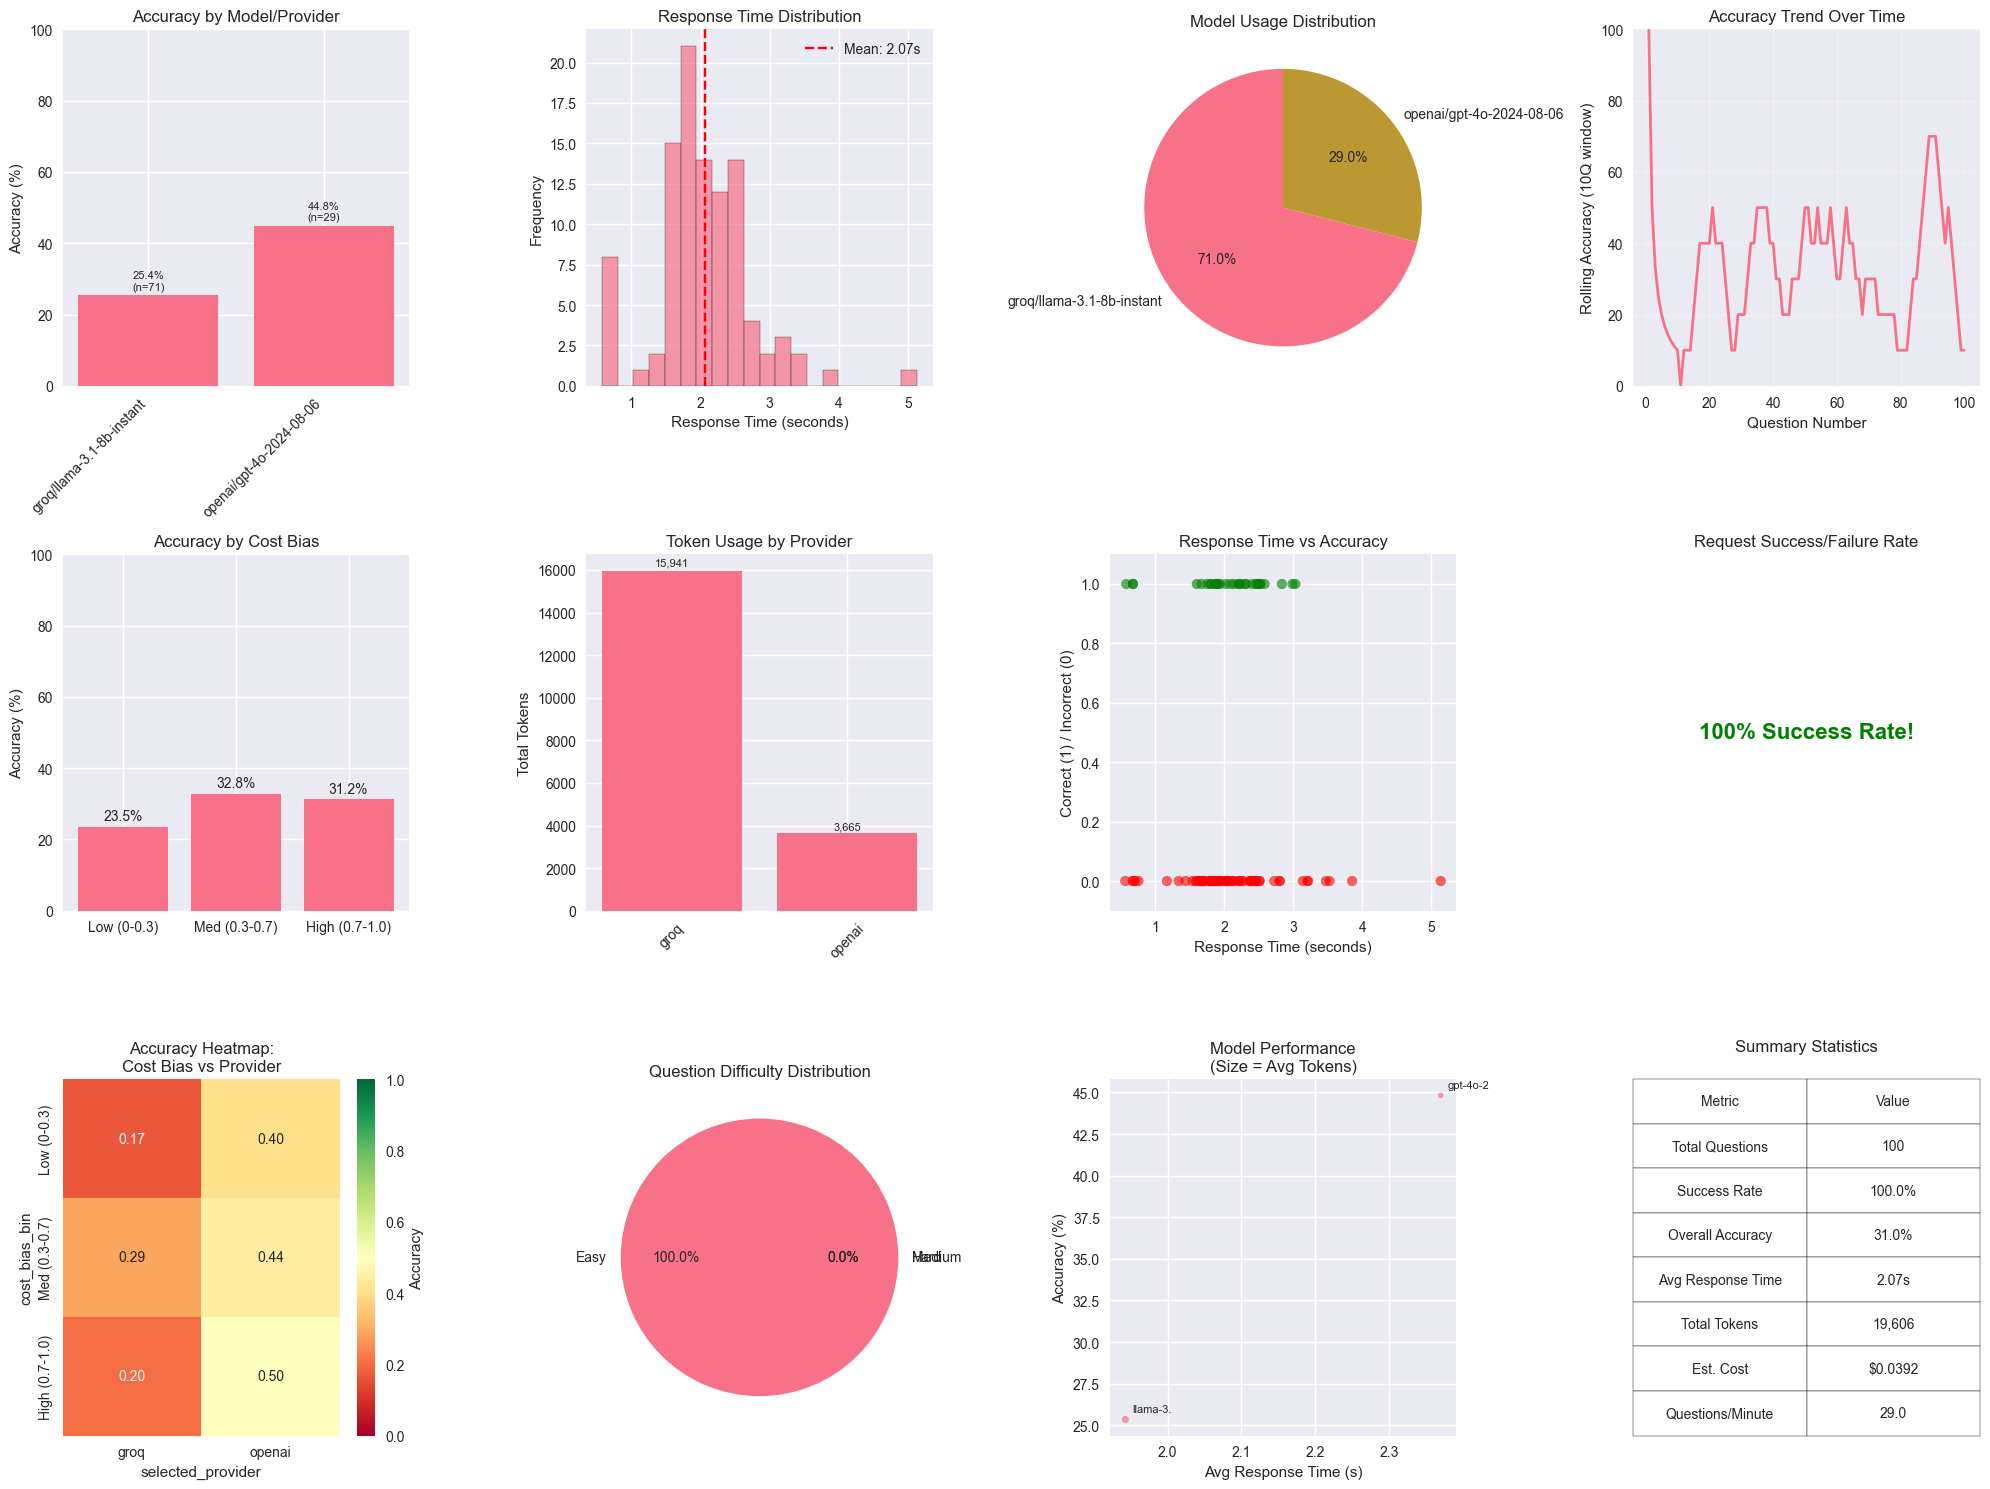


🔍 DETAILED ANALYSIS

🤖 MODEL PERFORMANCE RANKING:
1. openai/gpt-4o-2024-08-06
   Accuracy: 44.8% (29.0 questions)
   Avg Time: 2.37s
   Avg Tokens: 126
2. groq/llama-3.1-8b-instant
   Accuracy: 25.4% (71.0 questions)
   Avg Time: 1.94s
   Avg Tokens: 225

💰 COST EFFICIENCY ANALYSIS:
openai/gpt-4o-2024-08-06:
   Cost per question: $0.000253
   Cost per correct answer: $0.000564
   Efficiency score: 0.75
groq/llama-3.1-8b-instant:
   Cost per question: $0.000449
   Cost per correct answer: $0.001768
   Efficiency score: 0.29

💾 Visualization saved as: mmlu_analysis_20250713_221207.png


<Figure size 800x550 with 0 Axes>

In [14]:
# Advanced Analysis and Visualization of MMLU Benchmark Results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
import os
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def analyze_benchmark_results(csv_file_path=None):
    """
    Comprehensive analysis and visualization of MMLU benchmark results
    """
    
    # Find the most recent CSV file if none specified
    if csv_file_path is None:
        csv_files = glob("mmlu_math_benchmark_*.csv")
        if not csv_files:
            print("❌ No benchmark CSV files found!")
            return
        csv_file_path = max(csv_files, key=os.path.getctime)
        print(f"📊 Analyzing most recent file: {csv_file_path}")
    
    # Load the data
    try:
        df = pd.read_csv(csv_file_path)
        print(f"✅ Loaded {len(df)} records from {csv_file_path}")
    except Exception as e:
        print(f"❌ Error loading CSV: {e}")
        return
    
    # Basic statistics
    print("\n" + "="*60)
    print("📈 BENCHMARK SUMMARY STATISTICS")
    print("="*60)
    
    total_questions = len(df)
    successful_df = df[~df['selected_model'].isin(['error', 'failed'])]
    success_rate = len(successful_df) / total_questions * 100
    overall_accuracy = df['is_correct'].mean() * 100
    
    print(f"📊 Total Questions: {total_questions}")
    print(f"✅ Successful Requests: {len(successful_df)} ({success_rate:.1f}%)")
    print(f"🎯 Overall Accuracy: {overall_accuracy:.1f}%")
    print(f"⚡ Avg Response Time: {successful_df['response_time'].mean():.2f}s")
    print(f"💰 Total Tokens Used: {successful_df['total_tokens'].sum():,}")
    
    # Create comprehensive visualizations
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Accuracy by Model/Provider
    plt.subplot(3, 4, 1)
    if len(successful_df) > 0:
        model_accuracy = successful_df.groupby('model_provider_combo')['is_correct'].agg(['mean', 'count']).reset_index()
        model_accuracy = model_accuracy[model_accuracy['count'] >= 5]  # Filter models with at least 5 questions
        
        if len(model_accuracy) > 0:
            bars = plt.bar(range(len(model_accuracy)), model_accuracy['mean'] * 100)
            plt.xticks(range(len(model_accuracy)), model_accuracy['model_provider_combo'], rotation=45, ha='right')
            plt.ylabel('Accuracy (%)')
            plt.title('Accuracy by Model/Provider')
            plt.ylim(0, 100)
            
            # Add value labels on bars
            for i, bar in enumerate(bars):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{height:.1f}%\n(n={model_accuracy.iloc[i]["count"]})',
                        ha='center', va='bottom', fontsize=8)
    
    # 2. Response Time Distribution
    plt.subplot(3, 4, 2)
    if len(successful_df) > 0:
        plt.hist(successful_df['response_time'], bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Response Time (seconds)')
        plt.ylabel('Frequency')
        plt.title('Response Time Distribution')
        plt.axvline(successful_df['response_time'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {successful_df["response_time"].mean():.2f}s')
        plt.legend()
    
    # 3. Model Usage Distribution
    plt.subplot(3, 4, 3)
    if len(successful_df) > 0:
        model_counts = successful_df['model_provider_combo'].value_counts()
        plt.pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title('Model Usage Distribution')
    
    # 4. Accuracy Over Time
    plt.subplot(3, 4, 4)
    if len(df) > 0:
        df['question_number'] = range(1, len(df) + 1)
        # Rolling accuracy (window of 10)
        rolling_accuracy = df['is_correct'].rolling(window=10, min_periods=1).mean() * 100
        plt.plot(df['question_number'], rolling_accuracy, linewidth=2)
        plt.xlabel('Question Number')
        plt.ylabel('Rolling Accuracy (10Q window)')
        plt.title('Accuracy Trend Over Time')
        plt.ylim(0, 100)
        plt.grid(True, alpha=0.3)
    
    # 5. Cost Bias vs Accuracy
    plt.subplot(3, 4, 5)
    if len(successful_df) > 0:
        # Bin cost bias into groups
        successful_df['cost_bias_bin'] = pd.cut(successful_df['cost_bias_used'], 
                                              bins=[0, 0.3, 0.7, 1.0], 
                                              labels=['Low (0-0.3)', 'Med (0.3-0.7)', 'High (0.7-1.0)'])
        
        cost_bias_accuracy = successful_df.groupby('cost_bias_bin')['is_correct'].mean() * 100
        bars = plt.bar(range(len(cost_bias_accuracy)), cost_bias_accuracy.values)
        plt.xticks(range(len(cost_bias_accuracy)), cost_bias_accuracy.index)
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy by Cost Bias')
        plt.ylim(0, 100)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom')
    
    # 6. Token Usage by Provider
    plt.subplot(3, 4, 6)
    if len(successful_df) > 0:
        provider_tokens = successful_df.groupby('selected_provider')['total_tokens'].sum()
        bars = plt.bar(range(len(provider_tokens)), provider_tokens.values)
        plt.xticks(range(len(provider_tokens)), provider_tokens.index, rotation=45)
        plt.ylabel('Total Tokens')
        plt.title('Token Usage by Provider')
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=8)
    
    # 7. Response Time vs Accuracy Scatter
    plt.subplot(3, 4, 7)
    if len(successful_df) > 0:
        colors = ['red' if not correct else 'green' for correct in successful_df['is_correct']]
        plt.scatter(successful_df['response_time'], successful_df['is_correct'], 
                   c=colors, alpha=0.6)
        plt.xlabel('Response Time (seconds)')
        plt.ylabel('Correct (1) / Incorrect (0)')
        plt.title('Response Time vs Accuracy')
        plt.ylim(-0.1, 1.1)
    
    # 8. Error Analysis
    plt.subplot(3, 4, 8)
    error_counts = df['selected_model'].value_counts()
    if 'error' in error_counts.index or 'failed' in error_counts.index:
        error_types = []
        error_values = []
        for error_type in ['error', 'failed']:
            if error_type in error_counts.index:
                error_types.append(error_type.title())
                error_values.append(error_counts[error_type])
        
        success_count = len(successful_df)
        error_types.append('Success')
        error_values.append(success_count)
        
        plt.pie(error_values, labels=error_types, autopct='%1.1f%%', startangle=90)
        plt.title('Request Success/Failure Rate')
    else:
        plt.text(0.5, 0.5, '100% Success Rate!', ha='center', va='center', 
                fontsize=16, fontweight='bold', color='green')
        plt.title('Request Success/Failure Rate')
        plt.axis('off')
    
    # 9. Accuracy Heatmap by Cost Bias and Provider
    plt.subplot(3, 4, 9)
    if len(successful_df) > 0 and len(successful_df.groupby(['cost_bias_bin', 'selected_provider']).size()) > 1:
        pivot_table = successful_df.pivot_table(values='is_correct', 
                                               index='cost_bias_bin', 
                                               columns='selected_provider', 
                                               aggfunc='mean')
        sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn', 
                   vmin=0, vmax=1, cbar_kws={'label': 'Accuracy'})
        plt.title('Accuracy Heatmap:\nCost Bias vs Provider')
    
    # 10. Question Difficulty Analysis (based on overall accuracy)
    plt.subplot(3, 4, 10)
    if len(df) > 0:
        # Categorize questions by difficulty based on accuracy
        df['difficulty'] = pd.cut(df.groupby('question_id')['is_correct'].transform('mean'),
                                bins=[0, 0.3, 0.7, 1.0],
                                labels=['Hard', 'Medium', 'Easy'])
        
        difficulty_counts = df['difficulty'].value_counts()
        plt.pie(difficulty_counts.values, labels=difficulty_counts.index, autopct='%1.1f%%')
        plt.title('Question Difficulty Distribution')
    
    # 11. Model Performance Comparison
    plt.subplot(3, 4, 11)
    if len(successful_df) > 0:
        model_stats = successful_df.groupby('model_provider_combo').agg({
            'is_correct': 'mean',
            'response_time': 'mean',
            'total_tokens': 'mean'
        }).reset_index()
        
        if len(model_stats) > 1:
            # Scatter plot: Accuracy vs Response Time, size = tokens
            scatter = plt.scatter(model_stats['response_time'], 
                                model_stats['is_correct'] * 100,
                                s=model_stats['total_tokens']/10,
                                alpha=0.7)
            
            # Add labels
            for i, row in model_stats.iterrows():
                plt.annotate(row['model_provider_combo'].split('/')[-1][:8], 
                           (row['response_time'], row['is_correct'] * 100),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
            
            plt.xlabel('Avg Response Time (s)')
            plt.ylabel('Accuracy (%)')
            plt.title('Model Performance\n(Size = Avg Tokens)')
    
    # 12. Summary Statistics Table
    plt.subplot(3, 4, 12)
    plt.axis('off')
    
    # Create summary table
    summary_stats = [
        ['Metric', 'Value'],
        ['Total Questions', f'{total_questions}'],
        ['Success Rate', f'{success_rate:.1f}%'],
        ['Overall Accuracy', f'{overall_accuracy:.1f}%'],
        ['Avg Response Time', f'{successful_df["response_time"].mean():.2f}s'],
        ['Total Tokens', f'{successful_df["total_tokens"].sum():,}'],
        ['Est. Cost', f'${successful_df["total_tokens"].sum() * 0.000002:.4f}'],
        ['Questions/Minute', f'{len(df) / (successful_df["response_time"].sum() / 60):.1f}']
    ]
    
    table = plt.table(cellText=summary_stats[1:], 
                     colLabels=summary_stats[0],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    plt.title('Summary Statistics', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Additional detailed analysis
    print("\n" + "="*60)
    print("🔍 DETAILED ANALYSIS")
    print("="*60)
    
    if len(successful_df) > 0:
        print("\n🤖 MODEL PERFORMANCE RANKING:")
        model_performance = successful_df.groupby('model_provider_combo').agg({
            'is_correct': ['mean', 'count'],
            'response_time': 'mean',
            'total_tokens': 'mean'
        }).round(3)
        
        model_performance.columns = ['Accuracy', 'Count', 'Avg_Time', 'Avg_Tokens']
        model_performance = model_performance[model_performance['Count'] >= 3]  # At least 3 questions
        model_performance = model_performance.sort_values('Accuracy', ascending=False)
        
        for i, (model, stats) in enumerate(model_performance.iterrows(), 1):
            print(f"{i}. {model}")
            print(f"   Accuracy: {stats['Accuracy']*100:.1f}% ({stats['Count']} questions)")
            print(f"   Avg Time: {stats['Avg_Time']:.2f}s")
            print(f"   Avg Tokens: {stats['Avg_Tokens']:.0f}")
        
        print("\n💰 COST EFFICIENCY ANALYSIS:")
        # Cost per correct answer
        for model, stats in model_performance.iterrows():
            cost_per_question = stats['Avg_Tokens'] * 0.000002
            cost_per_correct = cost_per_question / stats['Accuracy'] if stats['Accuracy'] > 0 else float('inf')
            efficiency_score = stats['Accuracy'] / (stats['Avg_Time'] * cost_per_question * 1000)
            
            print(f"{model}:")
            print(f"   Cost per question: ${cost_per_question:.6f}")
            print(f"   Cost per correct answer: ${cost_per_correct:.6f}")
            print(f"   Efficiency score: {efficiency_score:.2f}")
    
    # Save the analysis
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'mmlu_analysis_{timestamp}.png', dpi=300, bbox_inches='tight')
    print(f"\n💾 Visualization saved as: mmlu_analysis_{timestamp}.png")
    
    return df

# Run the analysis
print("🔬 COMPREHENSIVE MMLU BENCHMARK ANALYSIS")
print("📊 Loading and analyzing results...")
analyzed_df = analyze_benchmark_results()